# Projekt PRIAD

## Rozpoznawanie autora utworu literackiego na podstawie treści utworu z wykorzystaniem worka słów.

### Stanisław Maliński, Jan Stachurski

___

Importy

In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log

pd.options.display.float_format = "{:.3f}".format 

In [92]:
import warnings
warnings.filterwarnings("ignore")

Wczytywanie danych

In [93]:
data_path = "./data/"
file_list = os.listdir(data_path)
func = lambda  a : a.replace(".txt", "").split("-")
count_size = lambda a : os.stat(a).st_size
data = [[func(title)[0], func(title)[1], data_path + title, count_size(data_path + title)] for title in file_list]
files = pd.DataFrame(data, columns=['Author', 'Name of The work', 'FilePath', 'FileSize'])

Przedstawiam zestaw uczący. Mamy tutaj pozycję kilku Polskich autorów.

In [94]:
tmp = files.drop(columns=['Name of The work', 'FilePath', 'FileSize'])
tmp = pd.concat([tmp, pd.Series(np.where(tmp['Author']!=None,1,1))], axis=1).groupby('Author').sum()
tmp.columns = ['Book Count']
print(tmp.groupby('Author').sum())

                   Book Count
Author                       
AdamMickiewicz              7
HenrykSienkiewicz          11
Juliusz Słowacki            8


Wczytanie stop-słów:

In [95]:
delimeters = ["\\n", "'"]
stop_word = set()
with open("./stopyPL.txt", encoding="utf8") as f:
    for line in f:
        word = repr(line)
        for c in delimeters:
            word = word.replace(c, "")
        stop_word.add(word)

Projekt ten używa worka słów, który to przechowuje informacje na temat częstości występowania słów w danym dokumencie. Definiujemy tu dwie funckje jedna do standaryzacji słów tzn. usunięcia ewentualnych znaków graficznych takich jak kropka czy przecinek oraz ustawienie wielkości liter na małe aby słowa "Który" oraz "który" były zliczane jako to same słowo.
Druga funkcja służy do budowania worka słów.

In [96]:
special_chars= ".,-?()!\\\":;*…0123456789"
def normalize_text(word):
    for char in special_chars:
        word = word.replace(char, "")
    word = word.lower()
    return word

def get_text(FileName):
    out = ""
    n = 0
    with open(FileName, "r", encoding="utf8") as f:
        for line in f:
            out += line
            n += 1
        f.close()
    return (n, out)
        
# 0 - generete bag with all words, 1 - bag without stopwords, 2 - bag with only stopwords
def generate_word_bag(text, mode=0, nwords=None):
    word_bag = {}
    words_in_bag = 0
    f1 = text.split("\n")
    f = []  
    for w in f1:
        f += w.split()
    for word in f:
        if nwords is not None and words_in_bag >= nwords:
            break
        if word == '':
            continue
        if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
            words_in_bag += 1
            if word in word_bag:
                word_bag[word] += 1
            else:
                word_bag[word] = 1
    return word_bag

def bag_from_list(lst, mode=0, nwords=0):
    word_bag = {}
    words_in_bag = 0
    for word in lst:
        if words_in_bag >= nwords:
            break
        if word == '':
            continue
        if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
            words_in_bag += 1
            if word in word_bag:
                word_bag[word] += 1
            else:
                word_bag[word] = 1
    return word_bag  

Mamy już mały warsztat narzędzi do analizy utworów. Stworzymy teraz parę funckji, które pozwolą nam zgrabnie manipulować macierzą danych. 
merge_dics_to_df - łączy worki słów w ramkę danych, którą później wykorzystamy do nauki klasyfikatora.
tfidf - przekształca macierz zawierającą wystąpienia słów na macierz zawierającą ich wartości TF-IDF.

In [97]:
def merge_dics_to_df(dics, labels=None):
    tab = []
    word_found = set()
    index = []
    for dic in dics:
        words = list(dic.keys())
        for word in words:
            if not word in word_found:
                word_found.add(word)
                index.append(word)
                rec = []
                for dictionary in dics:
                    if word in dictionary:
                        rec.append(dictionary[word])
                        del dictionary[word]
                    else:
                        rec.append(0)
                tab.append(rec)
   
    df = pd.DataFrame(tab, columns=labels, index=index)   
    return df.T

In [98]:
def tfidf(data):
    df = data.copy()
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    inbooks = np.array((df > 0)*1).sum(axis=0)
    idf = [log(nbooks / val, 10) for val in inbooks]
    tfidf = pd.DataFrame((tf*np.array([idf,]*nbooks)*100), columns=df.columns)
    if w_l:
        tfidf['labels'] = pd.Series.tolist(labels)
    tfidf.replace([np.nan, np.inf, -np.inf], 0, inplace=True)
    return tfidf

Funkcja obliczająca częstość wystąpienia danego słowa.

In [99]:
def frequency(data):
    df = data.copy()
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    fdf = pd.DataFrame(tf, columns=df.columns)
    if w_l:
        fdf['labels'] =  pd.Series.tolist(labels)
    return fdf

Funkcja do usuwania słów z worka jeżeli nie wstępuje ono dostatecznie dużo razy w żadnym z dzieł.

In [100]:
def drop_threshold(df, threshold):
    to_drop = []
    w_l = False
    if 'labels' in df.columns:
        labels = df['labels']
        df = df.drop(columns='labels')
        w_l = True
    for col in df.columns:
        if (df[col] < threshold).all():
            to_drop.append(col)
    df = df.drop(columns=to_drop)
    if w_l:
        df['labels'] = pd.Series.tolist(labels)
    return df

Wczytanie i obliczenie słowników dla wszystkich utworów.

In [101]:
def load(files, mode=2):
    word_bags = []
    index = []
    labels = []

    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        n, cont = get_text(path)
        cont = normalize_text(cont)
        word_bags.append(generate_word_bag(cont, mode=mode))
        index.append(name)
        labels.append(label)
        
    df = merge_dics_to_df(word_bags)
    df['labels'] = labels
    df['Name'] = index
    df = df.set_index('Name')
    return df   

Jak widzimy mamy już ramkę danych, w której każdym obiektem jest dzieło a wektorem atrybutów jest częstość wystąpień poszczególnych słów w każdym z dzieł. Dodaliśmy również atrybut decyzyjny - nazwisko autora danego dzieła.

___

Przeprowadzimy teraz krótką analizę zbioru uczącego.

In [102]:
data1 = load(files, mode=1)
data1 = drop_threshold(data1, 50)
data2 = load(files, mode=2)
data2 = drop_threshold(data2, 50)
data3 = pd.concat([data1.drop(columns=['labels']), data2], axis=1)
data3 = drop_threshold(data3, 50)

In [103]:
grouped = data1.groupby('labels')
grouped.sum()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,79,78,15,43,10,58,29,65,32,978,...,0,0,0,0,0,0,0,0,0,0
HenrykSienkiewicz,350,591,117,200,410,689,697,814,297,0,...,87,51,88,1,0,0,0,0,0,0
Juliusz Słowacki,27,35,16,34,13,48,14,46,51,784,...,0,0,0,81,53,52,176,83,99,60


Mamy tu przedstawione parę metryk na podstawie, których możemy wciągnąć parę wniosków. Widzmy z pierwszej figury, że autor Słowacki używa jak jedyny słów takich jak "Kalego" czy "Anheli", na pierwszy rzut oka jest to dla nas dobra informacja, ponieważ znaleźliśmy słowo specyficzne dla jednego autora!

In [104]:
data1[data1['labels'] == "Juliusz Słowacki"]

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick,labels
Name,,,,,,,,,,,,,,,,,,,,,
Anhelli,0,3,3,0,0,8,2,3,0,0,...,0,0,0,52,52,0,0,0,0,Juliusz Słowacki
Balladyna,6,3,0,0,0,3,2,4,2,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Beniowski dalsze pieśni,7,13,8,12,2,10,5,10,6,0,...,0,0,51,0,0,0,0,0,0,Juliusz Słowacki
Beniowski pięć pierwszych pieśni,0,4,1,3,11,5,1,11,10,0,...,0,0,30,1,0,0,0,0,0,Juliusz Słowacki
Hugo,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Kordian,4,7,2,9,0,12,4,6,10,444,...,0,0,0,0,0,176,0,0,0,Juliusz Słowacki
Król Duch,0,2,1,6,0,5,0,1,4,0,...,0,0,0,0,0,0,0,0,0,Juliusz Słowacki
Maria Stuart,10,3,1,4,0,3,0,11,18,340,...,0,0,0,0,0,0,83,99,60,Juliusz Słowacki


Niestety już tu widzimy, że słowo charakterystyczne dla danego autora jest również charakterystyczne dla jego jednej książki. Co oznacza, że słowa te nie występują w innych jego dziełach. Fakt ten sprawia, że słowo to staje się zbędne podczas klasyfikacji. A więc poszukujemy słów, które występuje stosunkowo często u pewnego autora i występuje ono w każdym z jego dzieł. A więc poszukujemy słów o wysokiej częstości oraz małej wariancji częstości dla danego autora.

In [105]:
data11 = frequency(data1).groupby('labels')
data11.mean()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.007,0.005,0.001,0.005,0.001,0.006,0.003,0.007,0.003,0.084,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HenrykSienkiewicz,0.001,0.003,0.001,0.001,0.002,0.003,0.003,0.004,0.002,0.000,...,0.001,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Juliusz Słowacki,0.002,0.003,0.001,0.002,0.001,0.006,0.001,0.003,0.004,0.040,...,0.000,0.000,0.000,0.004,0.007,0.007,0.008,0.005,0.006,0.003


In [106]:
data11.var()

,dotąd,razem,zdaje,świata,zwłaszcza,dzień,czasu,czas,mojej,/,...,kalego,słoń,mzimu,beniowski,anhelli,szaman,kordian,rizzio,botwel,nick
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.014,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HenrykSienkiewicz,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Juliusz Słowacki,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006,...,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000


W celu usunięcia słów, które pojawiają się wyłącznie w pojedyńczych dziełach możemy przyjąć pewne założenie, iż klasyfikacje będziemy przeprowadzać jedynie na słowach strukturyzujących zdanie takie jak 'że', 'który' lub 'i'. Słowa te nie będą charakterystyczne dla pojedyńczego autora czy dzieła, ponieważ pojawiają sie one w języku każdego człowieka, za to częstość ich występowania, może (i najprawdopodobnie jest) uzależniona od przyzwyczajenia do pewnej maniery w jakiej pewna osoba mówi. Dodatkową korzyścią takiego rozwiązania jest zdecydowanie oszczędności obliczeniowe.

In [107]:
data22 = frequency(data2).groupby('labels')
data22.mean()

,jest,to,między,w,i,na,ta,się,której,ponieważ,...,dlatego,jednak,jakkolwiek,bardziej,również,bowiem,znów,gdyż,natomiast,jednakże
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.008,0.021,0.002,0.066,0.090,0.051,0.002,0.052,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HenrykSienkiewicz,0.008,0.028,0.002,0.052,0.091,0.044,0.001,0.062,0.002,0.001,...,0.001,0.003,0.000,0.001,0.001,0.001,0.002,0.002,0.001,0.001
Juliusz Słowacki,0.009,0.020,0.002,0.071,0.090,0.057,0.003,0.054,0.001,0.000,...,0.000,0.001,0.000,0.001,0.000,0.001,0.002,0.000,0.000,0.000


In [108]:
data22.var()

,jest,to,między,w,i,na,ta,się,której,ponieważ,...,dlatego,jednak,jakkolwiek,bardziej,również,bowiem,znów,gdyż,natomiast,jednakże
labels,,,,,,,,,,,,,,,,,,,,,
AdamMickiewicz,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HenrykSienkiewicz,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Juliusz Słowacki,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Już na tym poziomie widzmy pewne prawidłowości. Jak widać Sienkiewicz jako jedyny używa słowa 'jednakże' oraz 'natomiast', a mała wariancja dla tych słów implikuje, że autor ten używa tego słowa dość regularnie w swoich dziełach. Tą teze bardzo łatwo zweryfikować.

In [109]:
data2[data2['labels'] == 'HenrykSienkiewicz']['jednakże']

Name
Bez dogmatu                   16
Co się raz stało w Sydonie     0
Krzyżacy Tom I                52
Krzyżacy Tom II               65
OgniemIMieczemTom1            19
Pan Wołodyjowski              37
Potop Tom I                   20
Potop Tom II                  36
Potop Tom III                 13
Quo vadis                     50
W pustyni i w puszczy         66
Name: jednakże, dtype: int64

In [158]:
data2[data2['labels'] != 'HenrykSienkiewicz']['jednakże']

Name
DziadyII                            0
DziadyIII                           0
DziadyIV                            0
Grażyna                             0
KonradWallendrod                    0
PanTadeusz                          0
Żywila                              0
Anhelli                             0
Balladyna                           0
Beniowski dalsze pieśni             0
Beniowski pięć pierwszych pieśni    0
Hugo                                0
Kordian                             0
Król Duch                           0
Maria Stuart                        0
Name: jednakże, dtype: int64

Za pomocą pomiaru odległości kosinusowej sprawdźmy, czy podobne reguły występują wystarczająco często aby odróżnić teksty poszczególnych autorów.

In [153]:
def cosine_dist(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

Zrobimy to prezentując mapę ciepła prezentującą podobieństwo między poszczególnymi pozycjami na podstawie wartości TF-IDF. Pierwsza grafika to mapa ciepła opisana poszczególnymi tytułami, a druga to ta sama mapa z rozróżnieniem jedynie między autorami.

<AxesSubplot:>

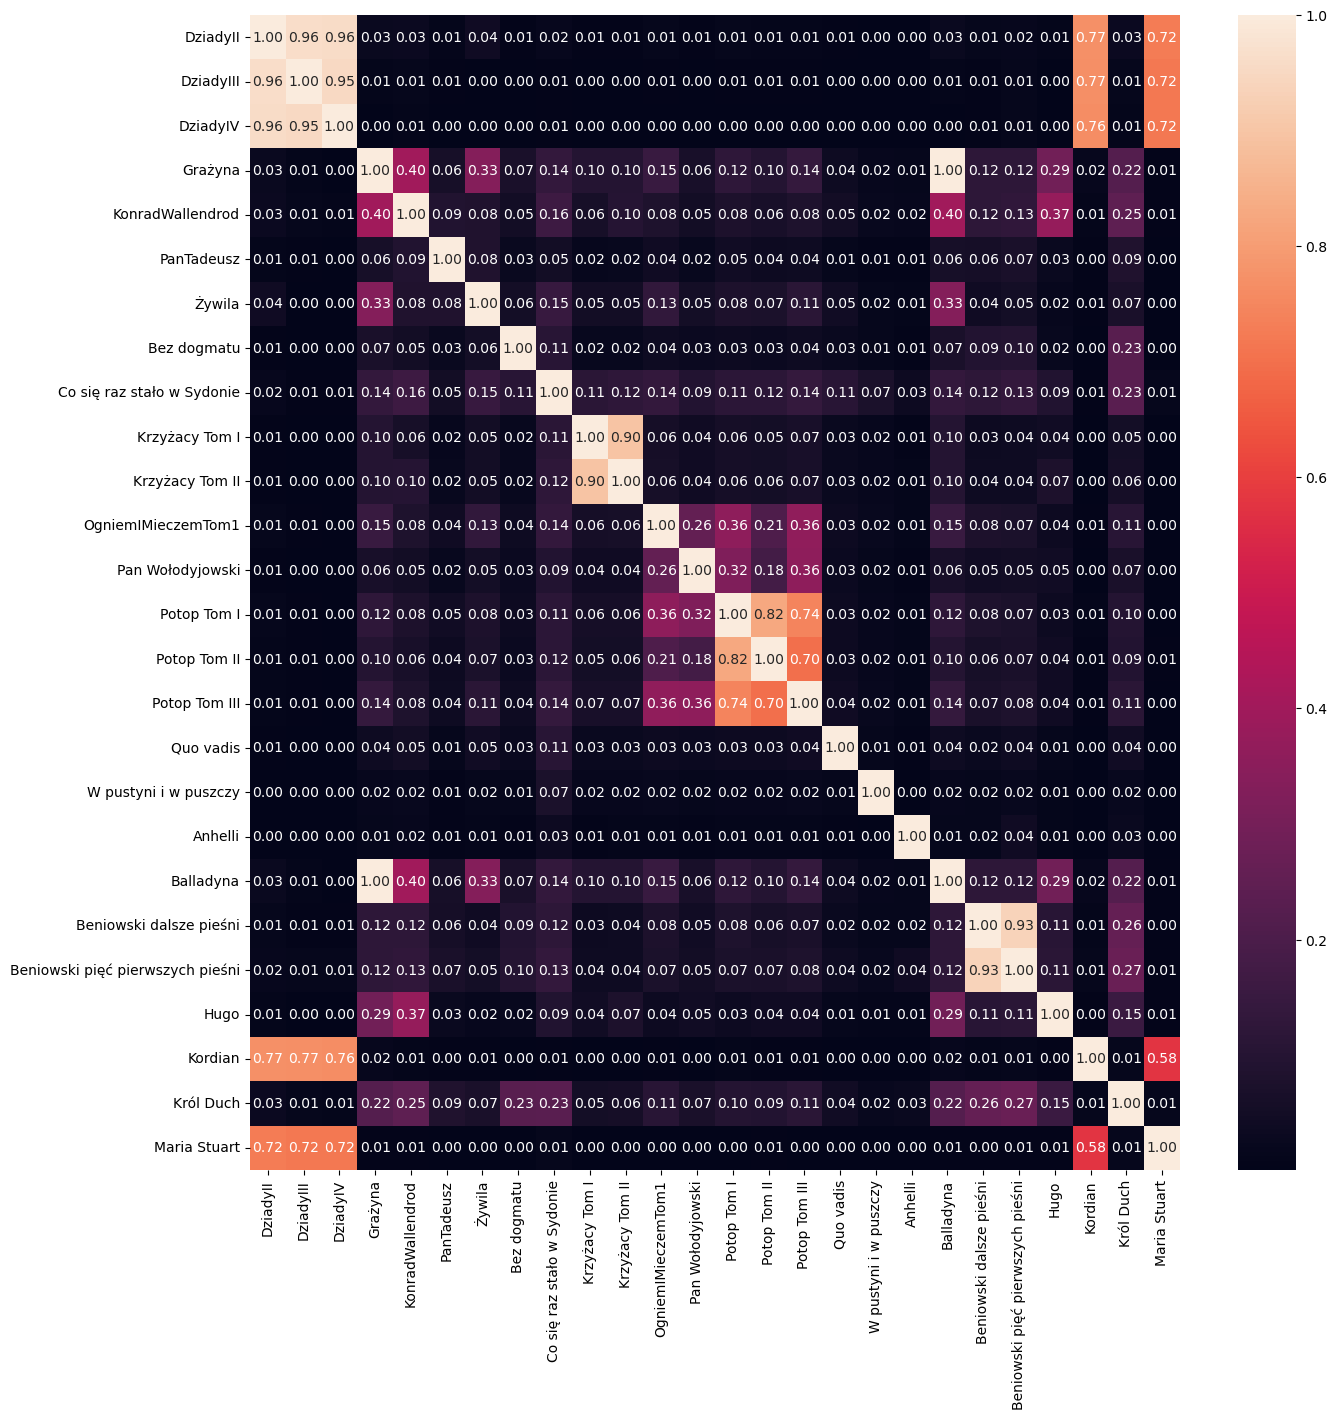

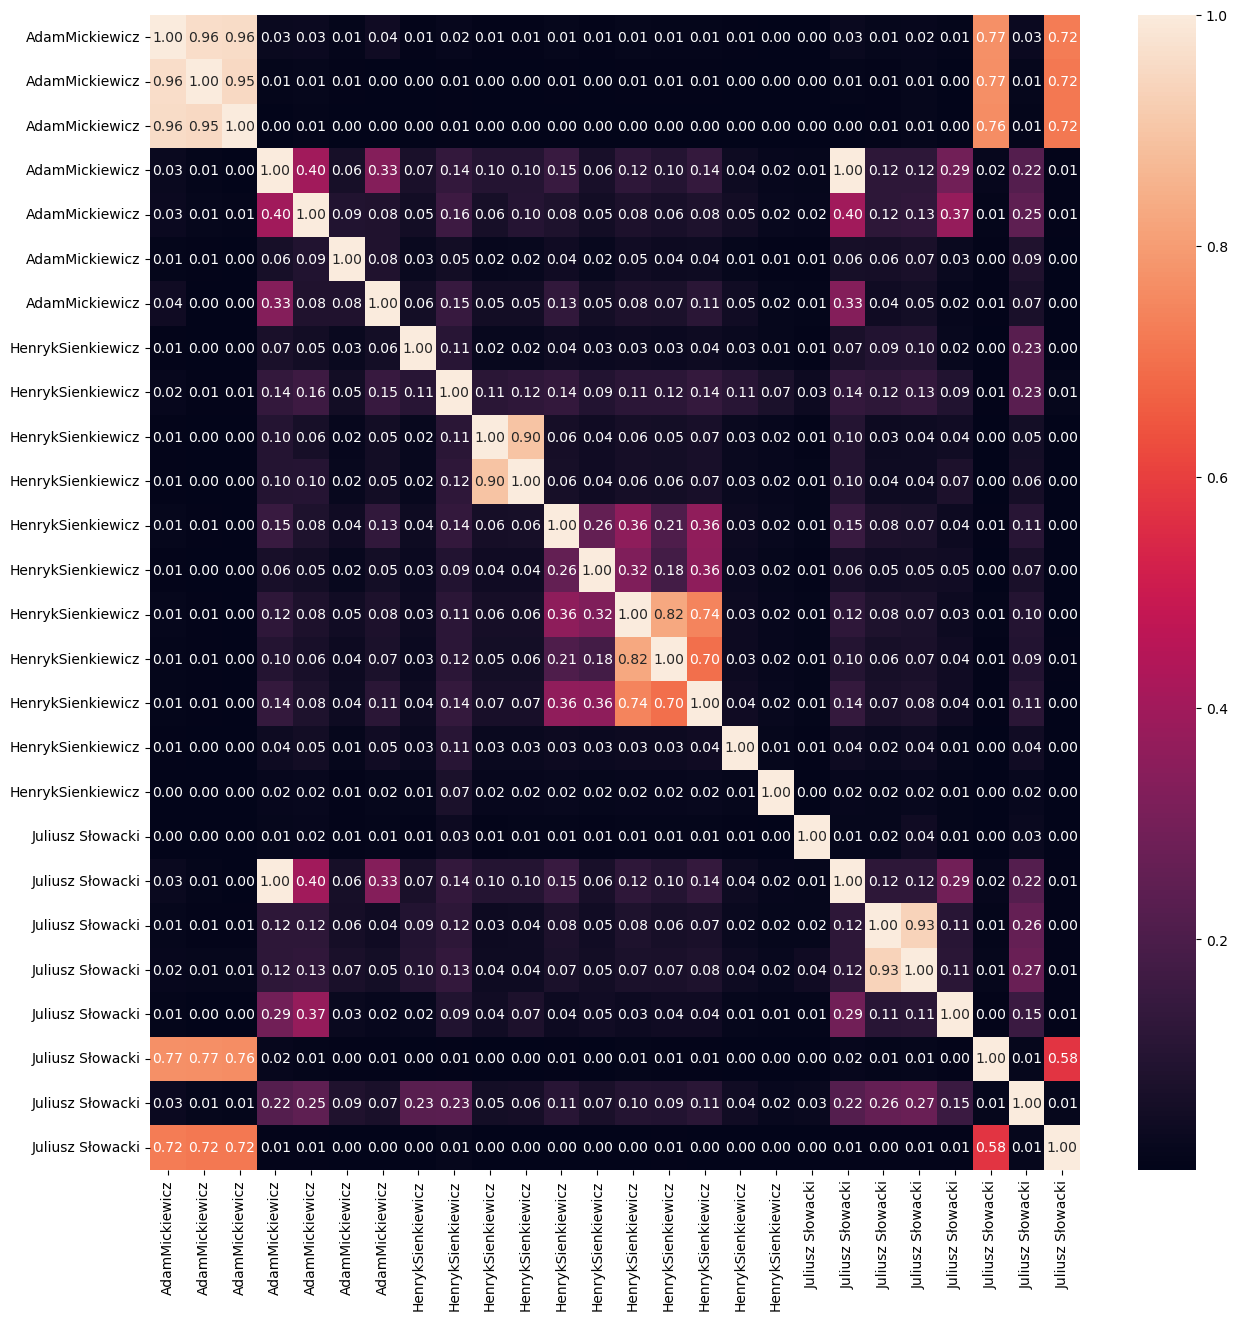

In [163]:
df = tfidf(data3)
names = data3.index.tolist()
labels = df['labels']
df = df.drop(columns='labels')
n = df.shape[0]
mapar = np.empty([n, n])
for i in range(n):
    for j in range(n):
        mapar[i, j] = cosine_dist(df.iloc[i,:], df.iloc[j,:])
plt.figure(figsize=(15,15), dpi = 100)
sns.heatmap(mapar, annot=mapar, fmt='0.2f', xticklabels=names, yticklabels=names)
plt.figure(figsize=(15,15), dpi = 100)
sns.heatmap(mapar, annot=mapar, fmt='0.2f', xticklabels=labels, yticklabels=labels)        


Z analizy map ciepła wynika, że występują podobieństawa między niektórymi dziełami tych samych autorów: wszystkie części "Dziadów" są do siebie bardzo podobne, tak samo jak wszystkie części "Krzyżaków" i w mniejszym stopniu potopu.
Niestety w przypadku większości dzieł danego autora podobieństwo nie jest zbyt duże - przykładowo żadne dzieło Mickiewicz spoza cyklu "Dziady" nie jest do nich podobne.
Występują także znaczące podobieństwa między dziełami różnych autorów - wszystkie części "Dziadów" są podobne zarówno do "Kordiana" jak i "Marii Stuart" Słowackiego co może utrudniać klasyfikację.

Spójrzmy jeszczę na podobną mapę ciepła wykonaną z użyciem macierzy częstości wystąpień słów.

<AxesSubplot:>

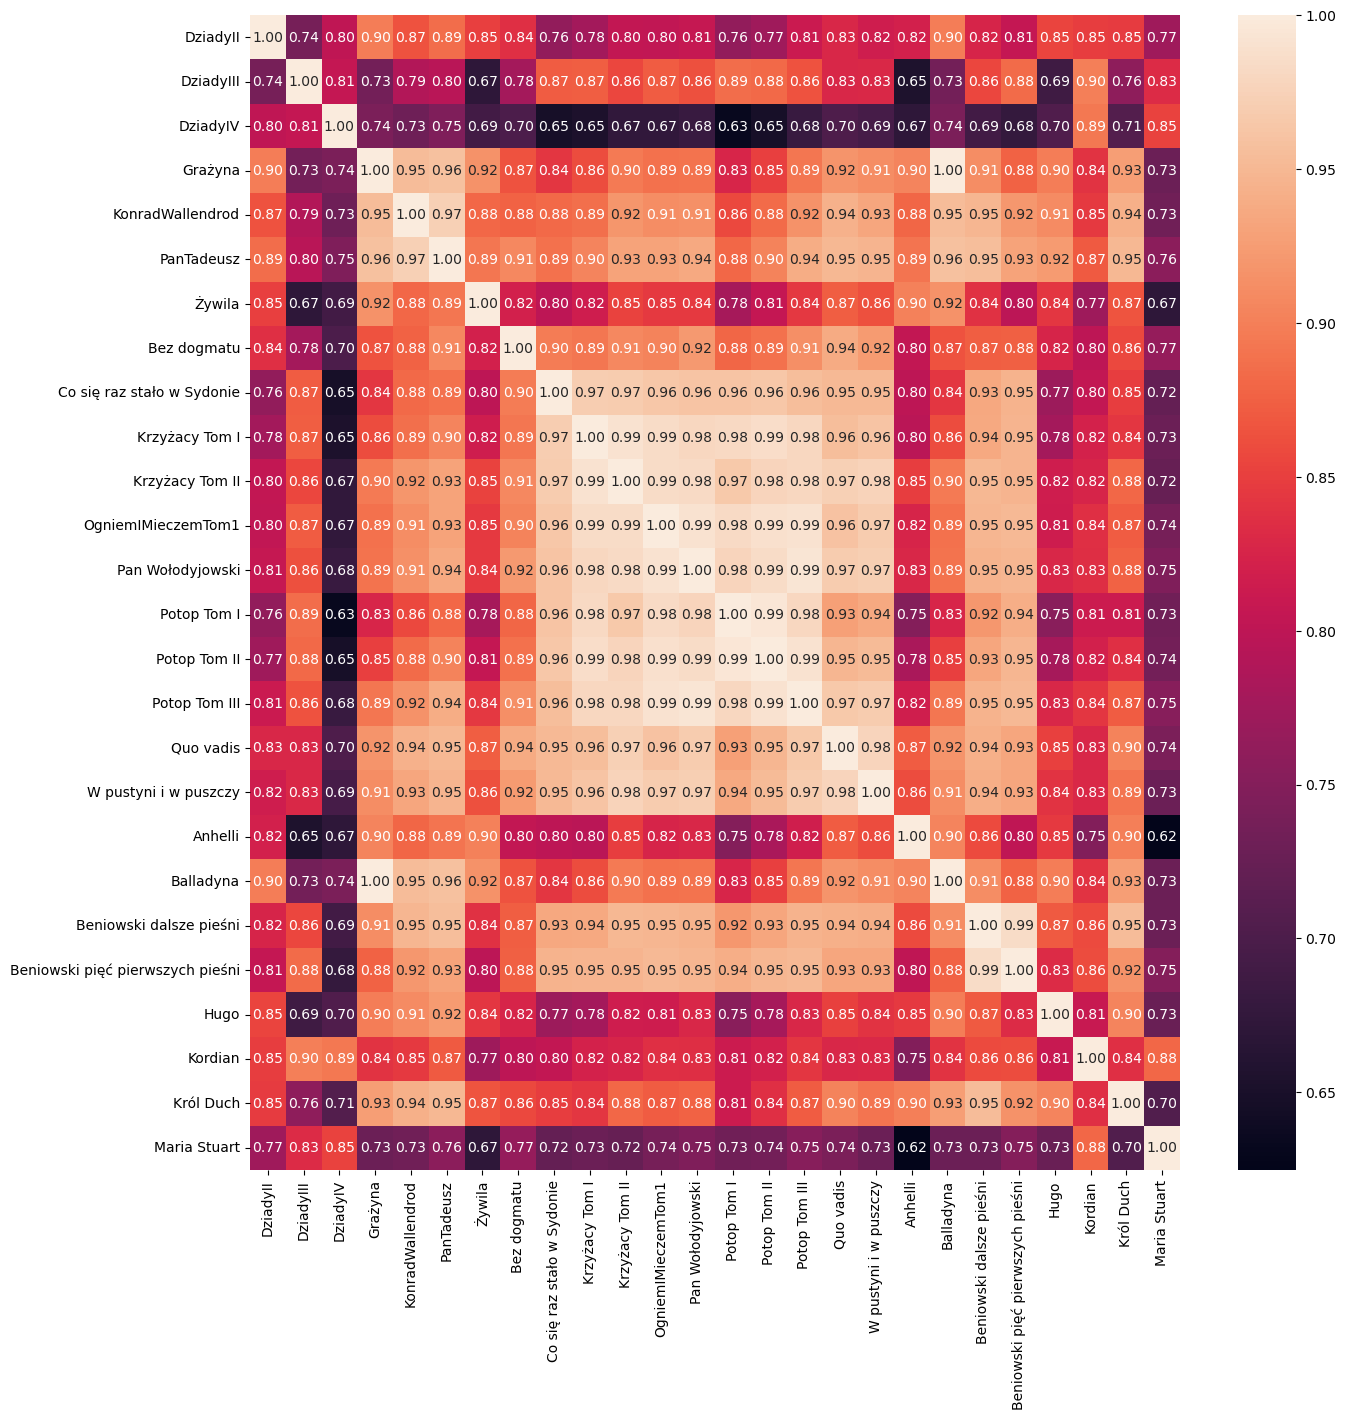

In [164]:
df = frequency(data3)
names = data3.index.tolist()
labels = df['labels']
df = df.drop(columns='labels')
n = df.shape[0]
mapar = np.empty([n, n])
for i in range(n):
    for j in range(n):
        mapar[i, j] = cosine_dist(df.iloc[i,:], df.iloc[j,:])
plt.figure(figsize=(15,15), dpi = 100)
sns.heatmap(mapar, annot=mapar, fmt='0.2f', xticklabels=names, yticklabels=names)

Jak widać stosując jako dane częstość wystąpień słów wszystkie dzieła są do siebie podobniejsze (pokazuje to skuteczność metryki TF-IDF)
Co ciekawe, na tej mapie ciepła wyraźnie widać wzajemne podobieństwo wszystkich dzieł Sienkiewicza, które nie było wyraźne na poprzednich mapach.

___

Teraz musimy stworzyć model, który będzie klasyfikował do jakiego autora należy dany utwór.

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

import random
import re

Metoda get_learning_data dzieli naszą macierz danych na dane uczące oraz testowe w pewnej proporcji. Dzięki temu będziemy mogli zweryfikować jak dobry nasz model jest.

In [113]:
def get_learning_data(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.drop(columns='labels'), df['labels'].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

In [114]:
def weryfikuj(model, data, show=True):
    model.fit(data['opis_ucz'], data['dec_ucz'])
    
    learn_s = model.score(data['opis_ucz'], data['dec_ucz'])
    test_s  = model.score(data['opis_test'], data['dec_test'])
    
    if show:
        print("\tWynik dla danych uczących: ", end="")
        print(learn_s)
        print("\tWynik dla danych testowych: ", end="")
        print(test_s)
    
    return learn_s, test_s

In [115]:
models = (("NS", KNeighborsClassifier(n_neighbors=1, metric='cosine')), 
          ("KNS5", KNeighborsClassifier(n_neighbors=5, metric='cosine')),
          ("KNS10", KNeighborsClassifier(n_neighbors=10, metric='cosine')), 
          ("BK", GaussianNB()),
          ("DT5", tree.DecisionTreeClassifier(max_depth=5)),
          ("DT10", tree.DecisionTreeClassifier(max_depth=10)))

Przeprowadzimy teraz klasyfikacje na danych testowych w pięciu wariantach:
* Worek słów składa się wyłącznie z stop słów.   
* Worek słów składa się ze słów, które nie są stop słowami.   
* Worek słów będzie składał się ze wszystkich słów.  
* Worek słów będzie sumą wszystkich słów używanych przez autora we wszystkich dziełach.   
* Worek słów będzie sumą wszystkich stop słów używanych przez autora we wszystkich dziełach.   

Do wykonania tego zadania posłużą nam metoday:

In [116]:
def merge_author(df):
    d = pd.concat([df['opis_ucz'], df['dec_ucz']], axis=1)
    d.groupby('labels').sum()
    df['dec_ucz'] = d.loc[:,'labels']
    df['opis_ucz'] = d.drop(columns=['labels'])
    return df

In [117]:
def test_classifiers(df_o, tfidf_arg=False, NS=False, tries=100):
    res = {}
    df = df_o.copy()
    progress = len(models)*tries
    if not tfidf_arg:
        df = frequency(df)
    for index, name_mod in enumerate(models):
        name, mod = name_mod
        if NS and name != 'NS': continue
        if mod is None:
            break
        sum_t = 0
        sum_l = 0
        line = "Ukończono w {pr:.2f}%"
        for i in range(tries):
            data = get_learning_data(df, 0.3)
            if tfidf_arg:
                data['opis_ucz'] = tfidf(data['opis_ucz'])
                data['opis_test'] = tfidf(data['opis_test'])
            d_l, d_t= weryfikuj(mod, data, show=False)
            sum_l += d_l
            sum_t += d_t
            if NS:
                print(line.format(pr=(index*tries + i + 1)*100/tries,) , end='\r')
            else:
                print(line.format(pr=(index*tries + i + 1)*100/progress,) , end='\r')
        res[name] = (sum_l/tries, sum_t/tries)
    respd = pd.DataFrame(res, index=["uczące", "testowe"])
    
    return respd.T.sort_values(by='testowe')

Najpierw wykonamy klasyfikacje wyłącznie używając częstości wystąpień danych słów w danym dziele:

Klasyfickaja bez stop słów


<AxesSubplot:>

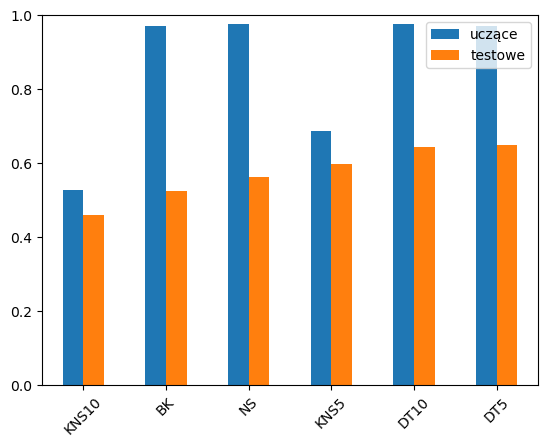

In [118]:
print("Klasyfickaja bez stop słów")
respd1 = test_classifiers(data1, tries=100)
respd1.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na stop słowach


<AxesSubplot:>

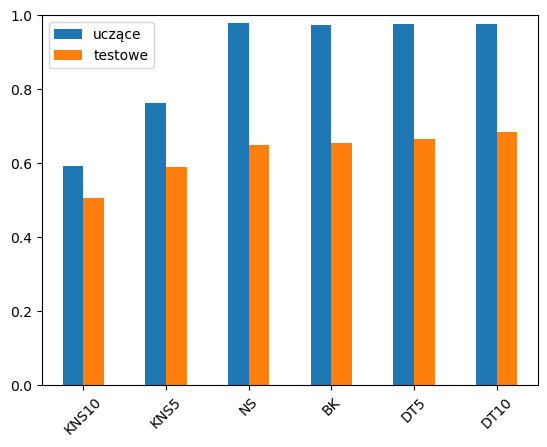

In [119]:
print("Klasyfickaja na stop słowach")
respd2 = test_classifiers(data2, tries=100)
respd2.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na wszystkich słowach


<AxesSubplot:>

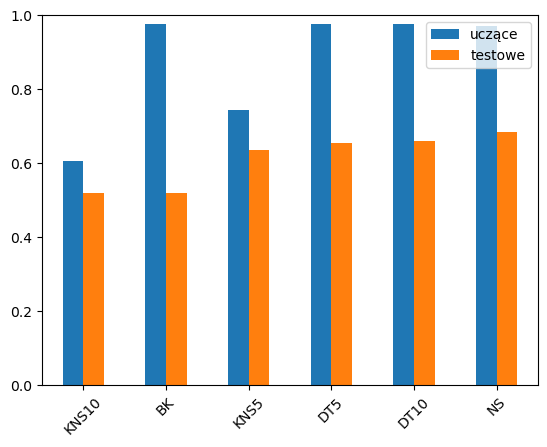

In [120]:
print("Klasyfickaja na wszystkich słowach")
respd3 = test_classifiers(data3, tries=100)
respd3.plot(kind='bar', rot = 45,  ylim=[0,1])

<AxesSubplot:>

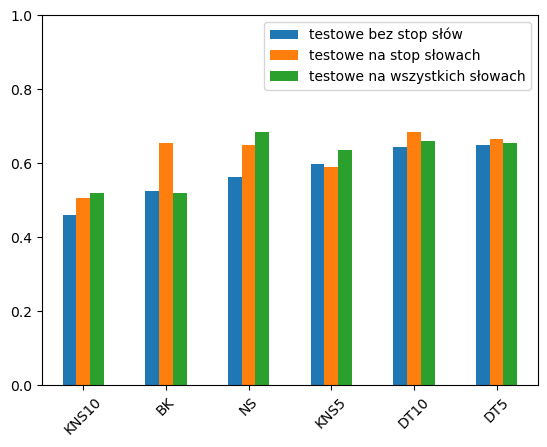

In [121]:
to_plot = pd.concat([respd1.drop(columns=['uczące']),
                        respd2.drop(columns=['uczące']),
                        respd3.drop(columns=['uczące'])], axis=1)
to_plot.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot.plot(kind='bar', rot = 45, ylim=[0,1])

Na podstawie tych klasyfikacji widzimy, że nie jesteśmy w stanie otrzymać bardzo wysokich wyników dla klasyfikatorów. Najlepsze wyniki otrzymujemy dla klasyfikatora Bayesa na stop słowach osiągając dokładność prawie 70%. 

Następną klasyfikacje wykonamy przy pomocy metryki tfidf.

Klasyfickaja bez stop słów z metryką TFIDF


<AxesSubplot:>

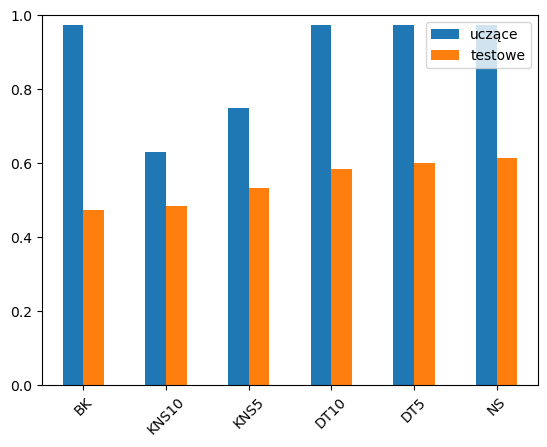

In [122]:
print("Klasyfickaja bez stop słów z metryką TFIDF")
respdTF1 = test_classifiers(data1, tfidf_arg=True, tries=100)
respdTF1.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na stop słowach z metryką TFIDF


<AxesSubplot:>

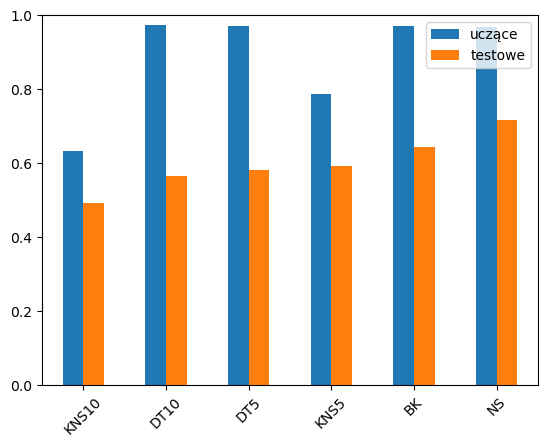

In [123]:
print("Klasyfickaja na stop słowach z metryką TFIDF")
respdTF2 = test_classifiers(data2, tfidf_arg=True, tries=100)
respdTF2.plot(kind='bar', rot = 45,  ylim=[0,1])

Klasyfickaja na wszyskich słowach z metryką TFIDF


<AxesSubplot:>

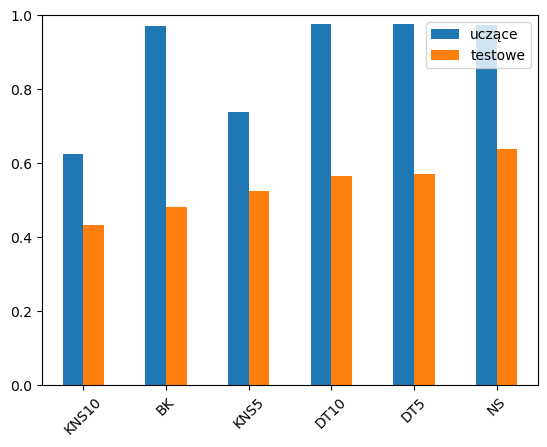

In [124]:
print("Klasyfickaja na wszyskich słowach z metryką TFIDF")
respdTF3 = test_classifiers(data3, tfidf_arg=True, tries=100)
respdTF3.plot(kind='bar', rot = 45,  ylim=[0,1])

<AxesSubplot:>

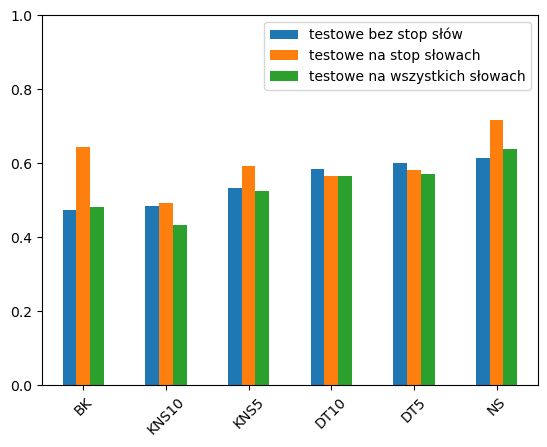

In [125]:
to_plot_TF = pd.concat([respdTF1.drop(columns=['uczące']),
                        respdTF2.drop(columns=['uczące']),
                        respdTF3.drop(columns=['uczące'])], axis=1)
to_plot_TF.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot_TF.plot(kind='bar', rot = 45, ylim=[0,1])

Przy użyciu metryki TFIDF udało nam się trochę "ulepszyć" zbiór uczący. Jak widzimy teraz wyniki uzyskiwane przez poszczególne klasyfikatory są trochę lepsze

Klasyfikacja gdy łączymy wszystkie dzieła 1 autora.

In [126]:
print("Klasyfickaja na stop słowach")
respdNS1 = test_classifiers(data1, NS=True, tries=1000)
print("Klasyfickaja bez stop słów")
respdNS2 = test_classifiers(data2, NS=True, tries=1000)
print("Klasyfickaja na wszystkich słowach")
respdNS3 = test_classifiers(data3, NS=True, tries=1000)
print("##################################")

Klasyfickaja na stop słowach
Klasyfickaja bez stop słów
Klasyfickaja na wszystkich słowach
##################################


<AxesSubplot:>

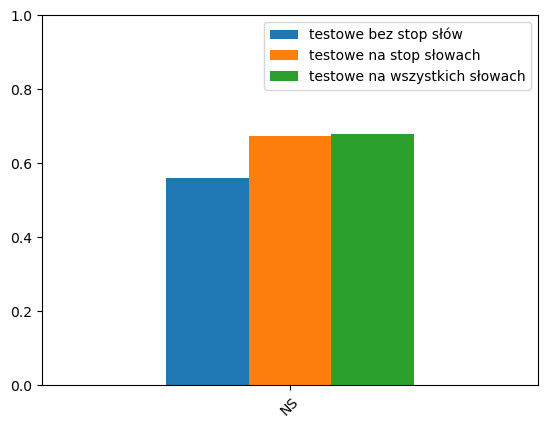

In [127]:
to_plot_NS = pd.concat([respdNS1.drop(columns=['uczące']),
                        respdNS2.drop(columns=['uczące']),
                        respdNS3.drop(columns=['uczące'])], axis=1)
to_plot_NS.columns = ['testowe bez stop słów', 'testowe na stop słowach', 'testowe na wszystkich słowach']
to_plot_NS.plot(kind='bar', rot = 45,  ylim=[0,1])

Przy wykorzystaniu prototypu autora uzyskujemy podobne do siebie wyniki niezależnie od przyjętej metody. Choć minimalnie lepszy okazały się być worki słów na wszystkich słowach, jednakże (żaden ze mnie Sienkiewicz) różnica między danymi na stop słowach są znikome a oszczędność obliczeniowa jest duża, co może być ważną cechą do odnotowania.

In [75]:
def test_for_lengths(model, traindf, files, mini=100, maxi=5100, step=1000, tries=10):
    classificator = model
    classificator.fit(traindf.drop(columns='labels'), traindf['labels'])
    books = []
    labels = []
    index = []
    results = []
    sizes = []
    nmin = np.Infinity
    
    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        labels.append(label)
        index.append(name)
        n, cont = get_text(path)
        cont = normalize_text(cont)
        cont = cont.replace('\n', ' ')
        words = cont.split(' ')
        nmin = min(nmin, len(words))
        books.append(words)
        
    line = "Ukończono w {pr:.2f}%"
    s = (maxi - mini)//step
    progress = s*tries
    
    for i in range(mini, maxi + 1, step):
        sum = 0
        if i >= nmin:
            break
        for t in range(tries):
            print(line.format(pr=(((i - mini)//step*tries + t + 1)*100/progress)), end='\r')         
            bags = []
            
            for text in books:
                start = random.randint(0, len(text) - i)
                bags.append(bag_from_list(text[start:], mode=0, nwords=i))
                
            df = merge_dics_to_df(bags)
            df = frequency(df)
            df['labels'] = labels
            df = df.merge(traindf, how='left')
            df = df[traindf.columns]
            df = df.fillna(0)
            
            sum += classificator.score(df.drop(columns='labels'), df['labels'])
        results.append(sum / tries)
        sizes.append(i)
    return results, sizes

In [ ]:
def test_for_lengths(model, traindf, files, mini=100, maxi=5100, step=1000, tries=10):
    classificator = model
    classificator.fit(traindf.drop(columns='labels'), traindf['labels'])
    books = []
    labels = []
    index = []
    results = []
    sizes = []
    nmin = np.Infinity
    
    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        labels.append(label)
        index.append(name)
        n, cont = get_text(path)
        cont = normalize_text(cont)
        cont = cont.replace('\n', ' ')
        words = cont.split(' ')
        nmin = min(nmin, len(words))
        books.append(words)
        
    line = "Ukończono w {pr:.2f}%"
    s = (maxi - mini)//step
    progress = s*tries
    
    for i in range(mini, maxi + 1, step):
        sum = 0
        if i >= nmin:
            break
        for t in range(tries):
            print(line.format(pr=(((i - mini)//step*tries + t + 1)*100/progress)), end='\r')         
            bags = []
            
            for text in books:
                start = random.randint(0, len(text) - i)
                bags.append(bag_from_list(text[start:], mode=0, nwords=i))
                
            df = merge_dics_to_df(bags)
            df = frequency(df)
            df['labels'] = labels
            df = df.merge(traindf, how='left')
            df = df[traindf.columns]
            df = df.fillna(0)
            
            sum += classificator.score(df.drop(columns='labels'), df['labels'])
        results.append(sum / tries)
        sizes.append(i)
    return results, sizes

In [69]:
data = load(files.drop([12, 31, 38]), mode=0)
fdata = frequency(data)

In [77]:
r, s = test_for_lengths(tree.DecisionTreeClassifier(max_depth=5), fdata, files.loc[[12, 31, 38],:], mini=100, maxi=2000, step=100, tries=10)
print('rozmiary: ', s)
print(r)

rozmiary:  [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
[0.4333333333333333, 0.33333333333333337, 0.4, 0.3666666666666667, 0.4666666666666666, 0.4, 0.33333333333333337, 0.33333333333333337, 0.4, 0.33333333333333337, 0.33333333333333337, 0.4333333333333333, 0.36666666666666664, 0.3666666666666667, 0.33333333333333337, 0.3666666666666667, 0.3666666666666667, 0.3666666666666667, 0.4333333333333334, 0.3666666666666667]


Text(0.5, 0, 'number of words')

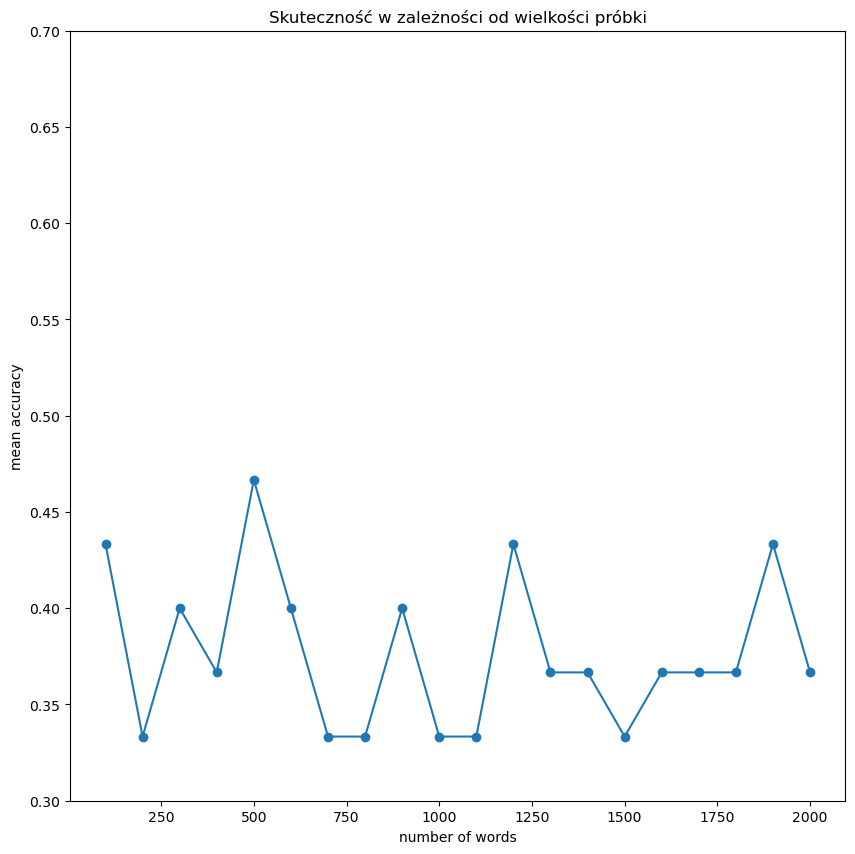

In [78]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(s, r, marker='o')
plt.title('Skuteczność w zależności od wielkości próbki')
plt.ylim([0.3, 0.7])
plt.ylabel('mean accuracy')
plt.xlabel('number of words')